## Using Notebook Environments
1. To run a cell, press `shift + enter`. The notebook will execute the code in the cell and move to the next cell. If the cell contains a markdown cell (text only), it will render the markdown and move to the next cell.
2. Since cells can be executed in any order and variables can be over-written, you may at some point feel that you have lost track of the state of your notebook. If this is the case, you can always restart the kernel by clicking Runtime in the menu bar (if you're using Colab) and selecting `Restart runtime`. This will clear all variables and outputs.
3. The final variable in a cell will be printed on the screen. If you want to print multiple variables, use the `print()` function as usual.

Notebook environments support code cells and markdown cells. For the purposes of this workshop, markdown cells are used to provide high-level explanations of the code. More specific details are provided in the code cells themselves in the form of comments (lines beginning with `#`)


## Environment Setup
**Make sure to set your runtime to use a GPU by going to `Runtime` -> `Change runtime type` -> `Hardware accelerator` -> `T4 GPU`**

In [ ]:
import sys
if 'google.colab' in sys.modules:  # If in Google Colab environment
    # Installing requisite packages
    !pip install transformers accelerate &> /dev/null

    # Mount google drive to enable access to data files
    from google.colab import drive
    drive.mount('/content/drive')

    # Change working directory to health
    %cd /content/drive/MyDrive/LLM4BeSci_GSERM2024/day_4

In [2]:
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm_notebook as tqdm

## Loading the data
The goal of this analysis will be to evaluate the LLM's ability to model demographic differences. We will use evaluate this using a dataset on [vaccine hesitancy](https://www.kaggle.com/datasets/christianhritter/vaccine-hesitancy-canada-cosmo-survey?select=COSMO_in_Canada_Waves_1-8_FINAL.csv). The dataset contains the following columns:
1. `'age'`
2. `'gender'`
3. `'education'`
4. `'take_vaccine'`: Survey question on willingness to take a COVID-19 vaccine (1 (Strongly Disagree) to 7 (Strongly Agree))
5. `'mandatory_vaccine'`

It also contains three '`persona`' columns, which contain the demographic information in a prompt format:

1. `'persona_a'`: Gender, Age, Education
2. `'persona_b'`: Gender, Age
3. `'persona_c'`: Age, Education

We begin by loading the dataset as a `pandas.DataFrame`:

In [3]:
vaccine = pd.read_csv('vaccine_hesitancy.csv')
vaccine

,age,gender,education,take_vaccine,mandatory_vaccine,persona_a,persona_b,persona_c
0,Between 65 and 74,Woman,Postgraduate degree above bachelor's level,7,2,a woman aged between 65 and 74 with a postgrad...,a woman aged between 65 and 74,a person aged between 65 and 74 with a postgra...
1,Between 55 and 64,Woman,Bachelor's degree,7,6,a woman aged between 55 and 64 with a bachelor...,a woman aged between 55 and 64,a person aged between 55 and 64 with a bachelo...
2,Between 35 and 44,Woman,"College, CEGEP or other non-university certifi...",7,7,"a woman aged between 35 and 44 with a college,...",a woman aged between 35 and 44,a person aged between 35 and 44 with a college...
3,75 or older,Woman,High school diploma or equivalent,7,7,a woman aged 75 or older with a high school di...,a woman aged 75 or older,a person aged 75 or older with a high school d...
4,Between 45 and 54,Man,Postgraduate degree above bachelor's level,6,1,a man aged between 45 and 54 with a postgradua...,a man aged between 45 and 54,a person aged between 45 and 54 with a postgra...
...,...,...,...,...,...,...,...,...
295,Between 25 and 34,Man,Postgraduate degree above bachelor's level,1,1,a man aged between 25 and 34 with a postgradua...,a man aged between 25 and 34,a person aged between 25 and 34 with a postgra...
296,Between 45 and 54,Woman,"College, CEGEP or other non-university certifi...",6,5,"a woman aged between 45 and 54 with a college,...",a woman aged between 45 and 54,a person aged between 45 and 54 with a college...
297,Between 45 and 54,Man,Postgraduate degree above bachelor's level,4,1,a man aged between 45 and 54 with a postgradua...,a man aged between 45 and 54,a person aged between 45 and 54 with a postgra...
298,75 or older,Man,Postgraduate degree above bachelor's level,7,7,a man aged 75 or older with a postgraduate deg...,a man aged 75 or older,a person aged 75 or older with a postgraduate ...


We can use the `value_counts()` method to get an idea of the distribution of the data. For instance, we can look at the distribution of the `'take_vaccine'` column:

In [11]:
vaccine['take_vaccine'].value_counts()

take_vaccine
7    172
6     36
1     26
4     25
5     18
2     12
3     11
Name: count, dtype: int64

**TASK 1**: Replace `'age`' above with other demographic column names (`'gender'`, `'education'`) to get an idea of the distribution of the data.

**TASK 2**: Replace `'take_vaccine'` above with other survey questions to get an idea of the distribution of the data. FYI: participants were asked the following question:

In the next section, we will generate responses to the survey question using the LLM. The survey question is as follows:

In [9]:
survey_q = """
    Please give your opinion on the following statement:
    
    'If an effective COVID-19 vaccine becomes available and is recommended for me, I would get it.'
    
    Choice:
    
    1 = Strongly Disagree
    2
    3
    4
    5
    6
    7 = Strongly Agree 
    
    Strictly only respond with the number corresponding to your choice and nothing else.
"""

## Comparing Phi-3's default distribution with the data
We will generate responses to the survey question using the LLM and compare the distribution of the generated responses with the actual data. We again use microsoft's Phi-3 model. We begin by loading the model and tokenizer:

In [ ]:
torch.random.manual_seed(42) # Set seed for reproducibility

# Load Phi-3
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-128k-instruct",
    device_map="cuda", # Use GPU
    torch_dtype=torch.float16,  # Use float16 for faster inference
    trust_remote_code=True, 
    attn_implementation='eager' # Faster inference on T4 GPUs
)

# Load tokenizer`
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-128k-instruct")

We will use the `pipeline` class to generate responses to the survey question. The `generation_args` dictionary contains the following arguments:

In [ ]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

generation_args = {
    "max_new_tokens": 10,  # Maximum number of tokens to generate
    "return_full_text": False, # Return only the generated text
    "do_sample": True, # Use greedy decoding
    "temperature": 1.0  # Temperature parameter 
}

We will firstly generate 100 responses to the survey question and compare the distribution of the generated responses with the actual data (without giving the model any demographic information):

In [ ]:
# Generate responses
take_vaccine_preds = [] # List to store generated responses
n_samples = 100 # Number of samples to generate
for i in tqdm(range(n_samples)):
    
    # Define prompt with JSON structure
    prompt = [{"role": "user", "content": survey_q}]  # Define prompt with JSON structure
    
    # Generate response
    response = pipe(prompt, **generation_args)[0]['generated_text']
    
    # Checks which integer corresponds to the response and appends to list
    possibles = ['1', '2', '3', '4', '5', '6', '7']
    pred = [int(x) for x in possibles if x in response][0]
    if len(pred) == 1:
        pred = pred[0]
        take_vaccine_preds.append(pred)

We can compare the distribution of the generated responses with the actual data using a histogram:

NameError: name 'take_vaccine_preds' is not defined

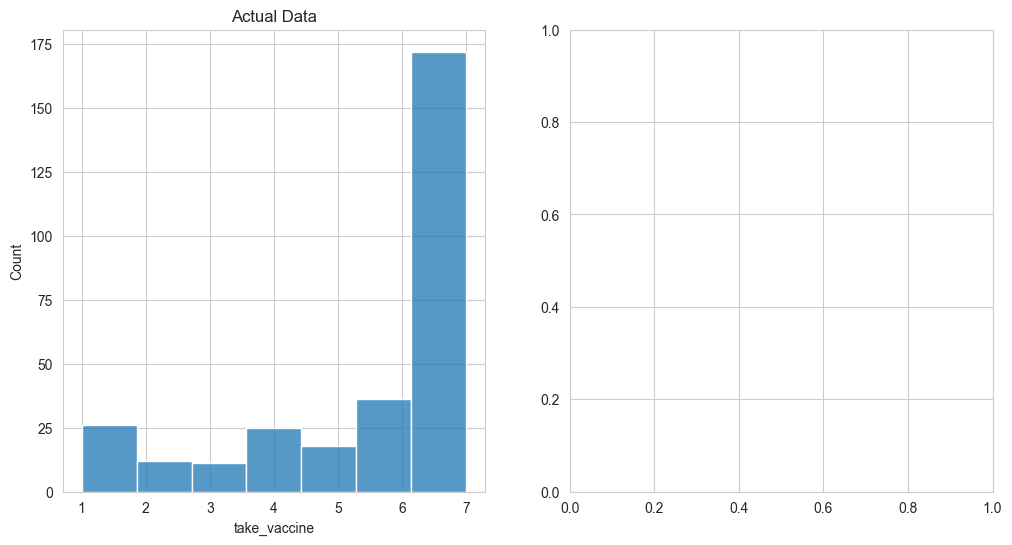

In [13]:
# Comparing distribution of generated responses with actual data
figs, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plotting actual data
sns.histplot(vaccine['take_vaccine'], stat='percent', bins=7, ax=axs[0])
axs[0].set_title('Actual Data')

# Plotting generated data
sns.histplot(take_vaccine_preds, stat='percent', bins=7, ax=axs[1])
axs[1].set_title('Generated Data')
axs[1].set_xlabel('take_vaccine')

**TASK 1**: Try playing around with larger values of `temperature` (e.g. `3.0`, `5.0`, `10.0`) to see how it affects the generated responses.

## Demographic Steering: Gender, Age, Education
As mentioned, our also contains 3 "personas", which contain different kinds of demographic information in a prompt format:

1. `'persona_a'`: Gender, Age, Education
2. `'persona_b'`: Gender, Age
3. `'persona_c'`: Age, Education

We will now evaluate each persona's effect on the generated responses. For each "participant", we will append the demographic information to `survey_q` and generate a response. For instance, the prompt for the first "participant" would look like this:

In [16]:
prompt = f"You are {vaccine['persona_a'][0]}.\n-------------------------------\n{survey_q}"
print(prompt)

You are a woman aged between 65 and 74 with a postgraduate degree above bachelor's level.
-------------------------------

    Please give your opinion on the following statement:
    
    'If an effective COVID-19 vaccine becomes available and is recommended for me, I would get it.'
    
    Choice:
    
    1 = Strongly Disagree
    2
    3
    4
    5
    6
    7 = Strongly Agree 
    
    Strictly only respond with the number corresponding to your choice and nothing else.


We will generate responses for each persona and compare the generated responses with the actual data. We will start with `'persona_a'` and a temperature of `3.0`, which we found to be the best temperature for this task out of [1.0, 3.0, 5.0, 10.0] using the previous task:

In [ ]:
generation_args = {
    "max_new_tokens": 10,  # Maximum number of tokens to generate
    "return_full_text": False, # Return only the generated text
    "do_sample": True, # Use greedy decoding
    "temperature": 3.0  # Temperature parameter 
}


demog_col = 'persona_a'  # Replace this for TASK 1

# Generate responses
take_vaccine_preds = [] # List to store generated responses
for demog_prompt in tqdm(vaccine[demog_col]):
    prompt = f"You are {demog_prompt}.\n-------------------------------\n{survey_q}"
    
    # Define prompt with JSON structure
    prompt = [{"role": "user", "content": prompt}]  # Define prompt with JSON structure
    
    # Generate response
    response = pipe(prompt, **generation_args)[0]['generated_text']
    
    # Checks which integer corresponds to the response
    possibles = ['1', '2', '3', '4', '5', '6', '7']
    pred = [int(x) for x in possibles if x in response]
    if len(pred) == 1:
        pred = pred[0]
        take_vaccine_preds.append(pred)
    else:
        take_vaccine_preds.append(None)
    
# Append generated responses to dataframe
vaccine[f'{demog_col}_preds'] = take_vaccine_preds
vaccine[f'{demog_col}_preds'].value_counts()

We can compare the generated responses with the actual data using a regression plot:

In [ ]:
# Comparing generated and actual data with a regression plot
ax = sns.regplot(
    x=f'{demog_col}_preds', y='take_vaccine', x_jitter=.1, y_jitter=.1, data=vaccine,
    scatter_kws={'alpha': 0.5}
)
x_y_lim = (.5, 7.5)
ax.set(xlim=x_y_lim, ylim=x_y_lim)
print(f"Correlation: {vaccine['take_vaccine'].corr(vaccine[f'{demog_col}_preds'])}")

**TASK 1**: Try using other demographic columns (`'persona_b'`, `'persona_c'`) by replacing `'persona_a'` above to see how the generated responses change.